In [82]:
import pandas as pd
import os
import numpy as np
from nltk.corpus import wordnet as wn
import tqdm
import torch
import csv
import math
from sklearn.metrics.pairwise import cosine_similarity
import re
import scipy
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm


In [83]:
#convert 768D embeddings into numpy arrays (easier to calculate cosine similarities later)
def embeddings_to_numpy(embeddings):
    current_embedding = []
    for n, row in embeddings.iterrows():
        current_embedding.append(row[0:768].to_numpy())
    embeddings['embed'] = current_embedding

    #add in ratings
    embeddings = embeddings[['embed', 1536, 1537]]
    return embeddings

In [84]:
def calculate_cosine_similarities(df):
    result = pd.DataFrame()
    for n, row in df.iterrows():
        embed1 = row['embed1']
        embed2 = row['embed2']

        cosine_similarity_value = cosine_similarity([embed1, embed2])[0][1]
        result = pd.concat([result, pd.DataFrame([[row['id']] + [row['word1']] +  [row['word2']] + [cosine_similarity_value]])])
    result.columns = ['index', 'word1', 'word2', 'cosine_similarity']
    return result
    

In [85]:
#calculating number of senses and synonyms for words we have
def calculate_num_senses(results):
    senses_1 = []
    senses_2 = []
    for n, row in results.iterrows():
        word = row['word1']
        senses_num = len(wn.synsets(word))
        senses_1.append(max(senses_num, 1))
        
        word = row['word2']
        senses_num = len(wn.synsets(word))
        senses_2.append(max(senses_num, 1))
    
    results['sense1'] = senses_1
    results['sense2'] = senses_2

    results['sense1'] = results['sense1'].apply(lambda x: math.log(x, 2))
    results['sense2'] = results['sense2'].apply(lambda x: math.log(x, 2))

    results['avg_sense'] = (results['sense1'] + results['sense2'])/2
    #checking if the words are the same
    results['same_word'] = (results['word1'] == results['word2']).apply(lambda x: 1 if x == True else 0)
    return results



In [86]:
#read in frequency data
freq = pd.read_csv("../../utils/word_frequency/bert_word_frequencies.csv")

#read in original ratings
data = pd.read_csv("ratings.txt", sep='\t+', header=None)
data.columns = ['id', 'word1', 'POS_word1', 'word2', 'POS_word2', 'word1_context', 'word2_context', 'average_rating', 0, 1, 2, 3, 4, 5, 6, 7, 8, 9]

#read in embeddings
embeddings1 = pd.read_csv("scsw_sentences1_embeddings.csv", header=None)
embeddings2 = pd.read_csv("scsw_sentences2_embeddings.csv", header=None)


#convert embeddings into vectors
embeddings1 = embeddings_to_numpy(embeddings1)
embeddings1.columns = ['embed1', 'id', 'word1']
embeddings2 = embeddings_to_numpy(embeddings2)
embeddings2.columns = ['embed2', 'id', 'word2']

embeddings_merged = embeddings1.set_index('id').join(embeddings2.set_index('id')).reset_index()
# for consistency, we're only looking at examples where the word in context was not captialized
# as a result, some of the examples may need to be dropped
# the results are nearly identical if these examples are included
embeddings_merged = embeddings_merged.dropna()



/tmp/ipykernel_232821/444017559.py:5: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  data = pd.read_csv("ratings.txt", sep='\t+', header=None)


In [87]:
#calculate cosine similarities between embeddings
scws_data = calculate_cosine_similarities(embeddings_merged)
print(len(scws_data))

#lowercase all keywords in order to join with frequency data
scws_data['word1'] = scws_data['word1'].apply(lambda x: x.lower())
scws_data['word2'] = scws_data['word2'].apply(lambda x: x.lower())

#join with frequency data
scws_data = scws_data.set_index('word1').join(freq.set_index('index'), how='inner')
scws_data = scws_data.set_index('word2').join(freq.set_index('index'), how='inner', lsuffix = "_1", rsuffix= "_2")
scws_data = scws_data.set_index('index').join(data.set_index(data.index), how='inner')


1620


In [88]:
#Calculating average logged frequency of both words
scws_data['freq_1'] = scws_data['freq_1'].apply(lambda x: math.log(x, 2))
scws_data['freq_2'] = scws_data['freq_2'].apply(lambda x: math.log(x, 2))
scws_data['avg_freq'] = scws_data[['freq_1','freq_2']].mean(axis=1)

scws_data = scws_data.dropna()

#Adding number of senses
scws_data = calculate_num_senses(scws_data)
scws_data = sm.add_constant(scws_data)

In [89]:
#Splitting the dataset into examples within and across words
subset1 = scws_data[scws_data['same_word'] == 1]
subset0 = scws_data[scws_data['same_word'] == 0]

#Using OLS to measure the effect of the following variables on cosine similarity
model1 = ['const', 'avg_freq']
model2 = ['const', 'average_rating']
model3 = ['const', 'avg_freq', 'average_rating']
model4 = ['const', 'avg_freq',  'average_rating', 'avg_sense']

for sample, same_or_different in zip([subset1, subset0], ['same target word', 'different target word']):
    for model in [model1, model2, model3, model4]:
        log_reg = sm.OLS(sample[['cosine_similarity']].values, sample[model].values).fit()
        print("\\begin{table*}")
        print(log_reg.summary(xname=model, yname='Cosine Similarity'))
        print("\\end{table*}")

\begin{table*}
                            OLS Regression Results                            
Dep. Variable:      Cosine Similarity   R-squared:                       0.120
Model:                            OLS   Adj. R-squared:                  0.115
Method:                 Least Squares   F-statistic:                     28.77
Date:                Fri, 18 Mar 2022   Prob (F-statistic):           2.12e-07
Time:                        11:24:27   Log-Likelihood:                 203.87
No. Observations:                 214   AIC:                            -403.7
Df Residuals:                     212   BIC:                            -397.0
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.0762      0.063     

# Appendix G

In [90]:
#creating our own train and dev splits
scws_data = scws_data.sample(frac=1, random_state=832).reset_index(drop=True)
train_sample = scws_data[:1000]
dev_sample = scws_data[1000:]


In [91]:
#using constant and average rating to predict cosine similarity
v1 = ['const', 'average_rating']

#fitting the model
average_rating_model = sm.OLS(train_sample[['cosine_similarity']].values, train_sample[v1].values).fit()

#generating predictions and the error between actual cosine and predicted cosine
dev_sample['prediction'] = average_rating_model.predict(dev_sample[v1].values)
dev_sample['error'] = dev_sample['cosine_similarity'] - dev_sample['prediction']


/tmp/ipykernel_232821/1488082561.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dev_sample['prediction'] = average_rating_model.predict(dev_sample[v1].values)
/tmp/ipykernel_232821/1488082561.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dev_sample['error'] = dev_sample['cosine_similarity'] - dev_sample['prediction']


In [92]:
#Calculate pearson's correlation between error and avg frequency
scipy.stats.pearsonr(x = dev_sample['error'].values, y = dev_sample['avg_freq'].values)

(-0.17993323482503087, 6.540940546442545e-06)

/u/nlp/anaconda/main/anaconda3/envs/katezhou/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y, data. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/u/nlp/anaconda/main/anaconda3/envs/katezhou/lib/python3.8/site-packages/seaborn/regression.py:592: UserWarning: legend_out is deprecated from the `lmplot` function signature. Please update your code to pass it using `facet_kws`.
  warnings.warn(msg, UserWarning)
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


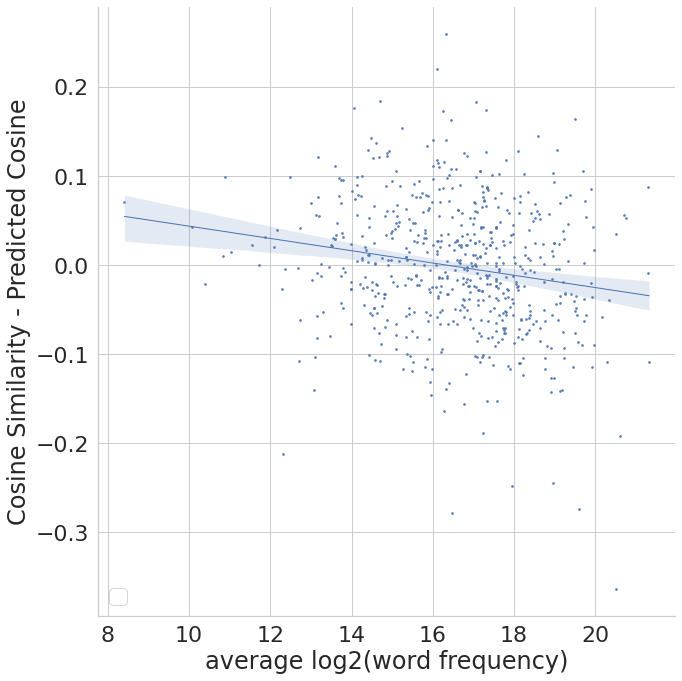

In [93]:
#create scatterplot with regression line
sns.set(rc={'figure.figsize':(6,3)}, style='whitegrid', font_scale=2,)

fig = sns.lmplot('avg_freq', 'error', dev_sample, legend_out=False, fit_reg=True,
                 scatter_kws={"s": 3, 'rasterized':True}, line_kws={"lw":1}, height=10, aspect=1)

fig.set_axis_labels("average log2(word frequency)", "Cosine Similarity - Predicted Cosine")
plt.legend(loc="lower left", markerscale=10)

plt.savefig('cosine_residual.pdf', bbox_inches='tight', dpi=600)

# Appendix D

In [95]:
#Using OLS to predict average human rating using the following features
model1 = ['const','avg_freq']
model2 = ['const','cosine_similarity']
model3 = ['const','avg_freq', 'avg_sense','cosine_similarity']
model4 = ['const', 'avg_sense', 'cosine_similarity', 'same_word']
model5 = ['const','avg_freq', 'avg_sense', 'cosine_similarity', 'same_word']

for model in  [model1, model2, model3, model4, model5]:
    log_reg = sm.OLS(sample[['average_rating']].values, sample[model].values).fit()
    print("\\begin{table*}[!h]")
    print(log_reg.summary(xname=model, yname='Human Rating'))
    print("\\end{table*}")

\begin{table*}[!h]
                            OLS Regression Results                            
Dep. Variable:           Human Rating   R-squared:                       0.014
Model:                            OLS   Adj. R-squared:                  0.013
Method:                 Least Squares   F-statistic:                     19.58
Date:                Fri, 18 Mar 2022   Prob (F-statistic):           1.04e-05
Time:                        11:26:46   Log-Likelihood:                -3086.0
No. Observations:                1406   AIC:                             6176.
Df Residuals:                    1404   BIC:                             6186.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          5.8719      0.508 

/u/nlp/anaconda/main/anaconda3/envs/katezhou/lib/python3.8/site-packages/statsmodels/regression/linear_model.py:1917: RuntimeWarning: divide by zero encountered in double_scalars
  return np.sqrt(eigvals[0]/eigvals[-1])
/u/nlp/anaconda/main/anaconda3/envs/katezhou/lib/python3.8/site-packages/statsmodels/regression/linear_model.py:1917: RuntimeWarning: divide by zero encountered in double_scalars
  return np.sqrt(eigvals[0]/eigvals[-1])
